<a href="https://colab.research.google.com/github/rdkworld/AIPND-2022/blob/main/Generalized/Generic_Pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [12]:
!pip install torchinfo
import torch
import torchvision
# Continue with regular imports
import matplotlib.pyplot as plt

from torch import nn
from torchvision import transforms
from torchinfo import summary
import tarfile
import os
from torchvision import transforms, models

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
#Mount Google Drive 
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [8]:
!mkdir data
!cp /content/drive/MyDrive/flowers.tar.gz data/ #copy from drive to colab
##!cp temp.pkl /content/drive/MyDrive/ #copy from colab to drive 
#!ls drive/
!ls data/*

data/flowers.tar.gz


In [10]:
with tarfile.open("data/flowers.tar.gz", "r") as tar_ref:
    print(f"[INFO] Unzipping flowers.tar data...") 
    tar_ref.extractall('data')

#Remove .zip file
if True:
   os.remove("data/flowers.tar.gz")

[INFO] Unzipping flowers.tar data...


EOFError: ignored

In [11]:
!ls data/*

data/flowers.tar.gz

data/flowers:
test  train  valid


In [ ]:
#Download Data
import os
#import zipfile
import tarfile

from pathlib import Path

import requests

def download_data(source: str, 
                  destination: str,
                  remove_source: bool = True) -> Path:
    """Downloads a zipped dataset from source and unzips to destination.

    Args:
        source (str): A link to a zipped file containing data.
        destination (str): A target directory to unzip data to.
        remove_source (bool): Whether to remove the source after downloading and extracting.
    
    Returns:
        pathlib.Path to downloaded data.
    
    Example usage:
        download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip",
                      destination="pizza_steak_sushi")
    """
    # Setup path to data folder
    data_path = Path("data/")
    image_path = data_path / destination

    # If the image folder doesn't exist, download it and prepare it... 
    if image_path.is_dir():
        print(f"[INFO] {image_path} directory exists, skipping download.")
    else:
        print(f"[INFO] Did not find {image_path} directory, creating one...")
        image_path.mkdir(parents=True, exist_ok=True)
        
    # Download data
    target_file = Path(source).name
    with open(data_path / target_file, "wb") as f:
        request = requests.get(source)
        print(f"[INFO] Downloading {target_file} from {source}...")
        f.write(request.content)

    # Unzip data
    # with zipfile.ZipFile(data_path / target_file, "r") as zip_ref:
    #     print(f"[INFO] Unzipping {target_file} data...") 
    #     zip_ref.extractall(image_path)

    with tarfile.open(data_path / target_file, "r") as tar_ref:
        print(f"[INFO] Unzipping {target_file} data...") 
        tar_ref.extractall(image_path)

    # Remove .zip file
    if remove_source:
        os.remove(data_path / target_file)
    
    return image_path



In [ ]:
image_path = download_data(source="https://www.robots.ox.ac.uk/~vgg/data/flowers/102/102flowers.tgz",
                           destination="102_flower_dataset")
image_path

[INFO] data/102_flower_dataset directory exists, skipping download.
[INFO] Downloading 102flowers.tgz from https://www.robots.ox.ac.uk/~vgg/data/flowers/102/102flowers.tgz...
[INFO] Unzipping 102flowers.tgz data...


PosixPath('data/102_flower_dataset')

In [13]:
!ls data/flowers/*

data/flowers/test:
1    12  18  23  29  34  4   45  50  56  61  67  72  78  83  89  94
10   13  19  24  3   35  40  46  51  57  62  68  73  79  84  9	 95
100  14  2   25  30  36  41  47  52  58  63  69  74  8	 85  90  96
101  15  20  26  31  37  42  48  53  59  64  7	 75  80  86  91  97
102  16  21  27  32  38  43  49  54  6	 65  70  76  81  87  92  98
11   17  22  28  33  39  44  5	 55  60  66  71  77  82  88  93  99

data/flowers/train:
1    12  18  23  29  34  4   45  50  56  61  67  72  78  83  89  94
10   13  19  24  3   35  40  46  51  57  62  68  73  79  84  9	 95
100  14  2   25  30  36  41  47  52  58  63  69  74  8	 85  90  96
101  15  20  26  31  37  42  48  53  59  64  7	 75  80  86  91  97
102  16  21  27  32  38  43  49  54  6	 65  70  76  81  87  92  98
11   17  22  28  33  39  44  5	 55  60  66  71  77  82  88  93  99

data/flowers/valid:
14  23	41  5	53  74	82  87	9   92	95
19  29	43  51	58  76	85  88	91  93


In [ ]:
total_count = 8189
train_count = int(0.7 * total_count)
valid_count = int(0.2 * total_count)
test_count = total_count - train_count - valid_count
train_dataset, valid_dataset, test_dataset = torch.utils.data.random_split(
    model_dataset, (train_count, valid_count, test_count)
)

In [14]:
# Setup device agnostic code# Setup device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [15]:
#Create Manual Dataloaders
"""
Contains functionality for creating PyTorch DataLoaders for 
image classification data.
"""
import os

from torchvision import datasets, transforms
from torch.utils.data import DataLoader

NUM_WORKERS = os.cpu_count()

def create_dataloaders(
    train_dir: str, 
    test_dir: str, 
    transform: transforms.Compose, 
    batch_size: int, 
    num_workers: int=NUM_WORKERS
):
  """Creates training and testing DataLoaders.

  Takes in a training directory and testing directory path and turns
  them into PyTorch Datasets and then into PyTorch DataLoaders.

  Args:
    train_dir: Path to training directory.
    test_dir: Path to testing directory.
    transform: torchvision transforms to perform on training and testing data.
    batch_size: Number of samples per batch in each of the DataLoaders.
    num_workers: An integer for number of workers per DataLoader.

  Returns:
    A tuple of (train_dataloader, test_dataloader, class_names).
    Where class_names is a list of the target classes.
    Example usage:
      train_dataloader, test_dataloader, class_names = \
        = create_dataloaders(train_dir=path/to/train_dir,
                             test_dir=path/to/test_dir,
                             transform=some_transform,
                             batch_size=32,
                             num_workers=4)
  """
  # Use ImageFolder to create dataset(s)
  train_data = datasets.ImageFolder(train_dir, transform=transform)
  test_data = datasets.ImageFolder(test_dir, transform=transform)

  # Get class names
  class_names = train_data.classes

  # Turn images into data loaders
  train_dataloader = DataLoader(
      train_data,
      batch_size=batch_size,
      shuffle=True,
      num_workers=num_workers,
      pin_memory=True,
  )
  test_dataloader = DataLoader(
      test_data,
      batch_size=batch_size,
      shuffle=False,
      num_workers=num_workers,
      pin_memory=True,
  )

  return train_dataloader, test_dataloader, class_names

In [16]:
#Create Manual Dataloaders
# Setup directories
from pathlib import Path
image_path = Path('data/flowers')
train_dir = image_path / "train"
test_dir = image_path / "test"

# Setup ImageNet normalization levels (turns all images into similar distribution as ImageNet)
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])

# Create transform pipeline manually
manual_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    normalize
])           
print(f"Manually created transforms: {manual_transforms}")

# Create autotransforms
# Get a set of pretrained model weights
weights = torchvision.models.ViT_B_16_Weights.DEFAULT
auto_transforms = weights.transforms()
print(f"Auto created transforms: {auto_transforms}")

# Create data loaders #data_setup
train_dataloader, test_dataloader, class_names = create_dataloaders( 
    train_dir=train_dir,
    test_dir=test_dir,
    #transform=manual_transforms, # use manually created transforms
    transform=auto_transforms, # use auto created transforms
    batch_size=32
)

train_dataloader, test_dataloader, class_names

Manually created transforms: Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=None)
    ToTensor()
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
)
Auto created transforms: ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)


(<torch.utils.data.dataloader.DataLoader at 0x7f435d6285d0>,
 ['1',
  '10',
  '100',
  '101',
  '102',
  '11',
  '12',
  '13',
  '14',
  '15',
  '16',
  '17',
  '18',
  '19',
  '2',
  '20',
  '21',
  '22',
  '23',
  '24',
  '25',
  '26',
  '27',
  '28',
  '29',
  '3',
  '30',
  '31',
  '32',
  '33',
  '34',
  '35',
  '36',
  '37',
  '38',
  '39',
  '4',
  '40',
  '41',
  '42',
  '43',
  '44',
  '45',
  '46',
  '47',
  '48',
  '49',
  '5',
  '50',
  '51',
  '52',
  '53',
  '54',
  '55',
  '56',
  '57',
  '58',
  '59',
  '6',
  '60',
  '61',
  '62',
  '63',
  '64',
  '65',
  '66',
  '67',
  '68',
  '69',
  '7',
  '70',
  '71',
  '72',
  '73',
  '74',
  '75',
  '76',
  '77',
  '78',
  '79',
  '8',
  '80',
  '81',
  '82',
  '83',
  '84',
  '85',
  '86',
  '87',
  '88',
  '89',
  '9',
  '90',
  '91',
  '92',
  '93',
  '94',
  '95',
  '96',
  '97',
  '98',
  '99'])

In [17]:
# Get a batch of images
image_batch, label_batch = next(iter(train_dataloader))

# Get a single image from the batch
image, label = image_batch[0], label_batch[0]

# View the batch shapes
image.shape, label

(torch.Size([3, 224, 224]), tensor(17))

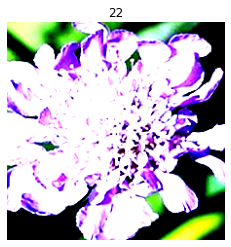

In [18]:
# Plot image with matplotlib
import matplotlib.pyplot as plt
plt.imshow(image.permute(1, 2, 0)) # rearrange image dimensions to suit matplotlib [color_channels, height, width] -> [height, width, color_channels]
plt.title(class_names[label])
plt.axis(False);

In [19]:
#Get pre-trained model
pretrained_vit_weights = torchvision.models.ViT_B_16_Weights.DEFAULT
pretrained_vit = torchvision.models.vit_b_16(weights = weights).to(device)

Downloading: "https://download.pytorch.org/models/vit_b_16-c867db91.pth" to /root/.cache/torch/hub/checkpoints/vit_b_16-c867db91.pth


  0%|          | 0.00/330M [00:00<?, ?B/s]

In [21]:
# Print a summary using torchinfo (uncomment for actual output)
summary(model=pretrained_vit, 
        input_size=(32, 3, 224, 224), # make sure this is "input_size", not "input_shape"
        # col_names=["input_size"], # uncomment for smaller output
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                                                Input Shape          Output Shape         Param #              Trainable
VisionTransformer (VisionTransformer)                                  [32, 3, 224, 224]    [32, 1000]           768                  True
├─Conv2d (conv_proj)                                                   [32, 3, 224, 224]    [32, 768, 14, 14]    590,592              True
├─Encoder (encoder)                                                    [32, 197, 768]       [32, 197, 768]       151,296              True
│    └─Dropout (dropout)                                               [32, 197, 768]       [32, 197, 768]       --                   --
│    └─Sequential (layers)                                             [32, 197, 768]       [32, 197, 768]       --                   True
│    │    └─EncoderBlock (encoder_layer_0)                             [32, 197, 768]       [32, 197, 768]       7,087,872            True
│    │    └─EncoderBlock

In [22]:
# 3. Freeze the base parameters
for parameter in pretrained_vit.parameters():
    parameter.requires_grad = False

# 4. Change the classifier head (set the seeds to ensure same initialization with linear head)
#set_seeds()
pretrained_vit.heads = nn.Linear(in_features=768, out_features=len(class_names)).to(device)
# pretrained_vit # uncomment for model output    

In [23]:
#engine
"""
Contains functions for training and testing a PyTorch model.
"""
import torch

from tqdm.auto import tqdm
from typing import Dict, List, Tuple

def train_step(model: torch.nn.Module, 
               dataloader: torch.utils.data.DataLoader, 
               loss_fn: torch.nn.Module, 
               optimizer: torch.optim.Optimizer,
               device: torch.device) -> Tuple[float, float]:
    """Trains a PyTorch model for a single epoch.

    Turns a target PyTorch model to training mode and then
    runs through all of the required training steps (forward
    pass, loss calculation, optimizer step).

    Args:
    model: A PyTorch model to be trained.
    dataloader: A DataLoader instance for the model to be trained on.
    loss_fn: A PyTorch loss function to minimize.
    optimizer: A PyTorch optimizer to help minimize the loss function.
    device: A target device to compute on (e.g. "cuda" or "cpu").

    Returns:
    A tuple of training loss and training accuracy metrics.
    In the form (train_loss, train_accuracy). For example:

    (0.1112, 0.8743)
    """
    # Put model in train mode
    model.train()

    # Setup train loss and train accuracy values
    train_loss, train_acc = 0, 0

    # Loop through data loader data batches
    for batch, (X, y) in enumerate(dataloader):
        # Send data to target device
        X, y = X.to(device), y.to(device)

        # 1. Forward pass
        y_pred = model(X)

        # 2. Calculate  and accumulate loss
        loss = loss_fn(y_pred, y)
        train_loss += loss.item() 

        # 3. Optimizer zero grad
        optimizer.zero_grad()

        # 4. Loss backward
        loss.backward()

        # 5. Optimizer step
        optimizer.step()

        # Calculate and accumulate accuracy metric across all batches
        y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
        train_acc += (y_pred_class == y).sum().item()/len(y_pred)

    # Adjust metrics to get average loss and accuracy per batch 
    train_loss = train_loss / len(dataloader)
    train_acc = train_acc / len(dataloader)
    return train_loss, train_acc

def test_step(model: torch.nn.Module, 
              dataloader: torch.utils.data.DataLoader, 
              loss_fn: torch.nn.Module,
              device: torch.device) -> Tuple[float, float]:
    """Tests a PyTorch model for a single epoch.

    Turns a target PyTorch model to "eval" mode and then performs
    a forward pass on a testing dataset.

    Args:
    model: A PyTorch model to be tested.
    dataloader: A DataLoader instance for the model to be tested on.
    loss_fn: A PyTorch loss function to calculate loss on the test data.
    device: A target device to compute on (e.g. "cuda" or "cpu").

    Returns:
    A tuple of testing loss and testing accuracy metrics.
    In the form (test_loss, test_accuracy). For example:

    (0.0223, 0.8985)
    """
    # Put model in eval mode
    model.eval() 

    # Setup test loss and test accuracy values
    test_loss, test_acc = 0, 0

    # Turn on inference context manager
    with torch.inference_mode():
        # Loop through DataLoader batches
        for batch, (X, y) in enumerate(dataloader):
            # Send data to target device
            X, y = X.to(device), y.to(device)

            # 1. Forward pass
            test_pred_logits = model(X)

            # 2. Calculate and accumulate loss
            loss = loss_fn(test_pred_logits, y)
            test_loss += loss.item()

            # Calculate and accumulate accuracy
            test_pred_labels = test_pred_logits.argmax(dim=1)
            test_acc += ((test_pred_labels == y).sum().item()/len(test_pred_labels))

    # Adjust metrics to get average loss and accuracy per batch 
    test_loss = test_loss / len(dataloader)
    test_acc = test_acc / len(dataloader)
    return test_loss, test_acc

def train(model: torch.nn.Module, 
          train_dataloader: torch.utils.data.DataLoader, 
          test_dataloader: torch.utils.data.DataLoader, 
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module,
          epochs: int,
          device: torch.device) -> Dict[str, List]:
    """Trains and tests a PyTorch model.

    Passes a target PyTorch models through train_step() and test_step()
    functions for a number of epochs, training and testing the model
    in the same epoch loop.

    Calculates, prints and stores evaluation metrics throughout.

    Args:
    model: A PyTorch model to be trained and tested.
    train_dataloader: A DataLoader instance for the model to be trained on.
    test_dataloader: A DataLoader instance for the model to be tested on.
    optimizer: A PyTorch optimizer to help minimize the loss function.
    loss_fn: A PyTorch loss function to calculate loss on both datasets.
    epochs: An integer indicating how many epochs to train for.
    device: A target device to compute on (e.g. "cuda" or "cpu").

    Returns:
    A dictionary of training and testing loss as well as training and
    testing accuracy metrics. Each metric has a value in a list for 
    each epoch.
    In the form: {train_loss: [...],
              train_acc: [...],
              test_loss: [...],
              test_acc: [...]} 
    For example if training for epochs=2: 
             {train_loss: [2.0616, 1.0537],
              train_acc: [0.3945, 0.3945],
              test_loss: [1.2641, 1.5706],
              test_acc: [0.3400, 0.2973]} 
    """
    # Create empty results dictionary
    results = {"train_loss": [],
               "train_acc": [],
               "test_loss": [],
               "test_acc": []
    }
    
    # Make sure model on target device
    model.to(device)

    # Loop through training and testing steps for a number of epochs
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model=model,
                                          dataloader=train_dataloader,
                                          loss_fn=loss_fn,
                                          optimizer=optimizer,
                                          device=device)
        test_loss, test_acc = test_step(model=model,
          dataloader=test_dataloader,
          loss_fn=loss_fn,
          device=device)

        # Print out what's happening
        print(
          f"Epoch: {epoch+1} | "
          f"train_loss: {train_loss:.4f} | "
          f"train_acc: {train_acc:.4f} | "
          f"test_loss: {test_loss:.4f} | "
          f"test_acc: {test_acc:.4f}"
        )

        # Update results dictionary
        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)

    # Return the filled results at the end of the epochs
    return results

In [24]:
# Setup dataloaders
train_dataloader_pretrained, test_dataloader_pretrained, class_names = create_dataloaders(train_dir=train_dir,
                                                                                                     test_dir=test_dir,
                                                                                                     transform=auto_transforms,
                                                                                                     batch_size=32) # Could increase if we had more samples, such as here: https://arxiv.org/abs/2205.01580 (there are other improvements there too...)


In [26]:
# Create optimizer and loss function
optimizer = torch.optim.Adam(params=pretrained_vit.parameters(), 
                             lr=1e-3)
loss_fn = torch.nn.CrossEntropyLoss()

# Train the classifier head of the pretrained ViT feature extractor model
#set_seeds()
pretrained_vit_results = train(model=pretrained_vit,
                                      train_dataloader=train_dataloader_pretrained,
                                      test_dataloader=test_dataloader_pretrained,
                                      optimizer=optimizer,
                                      loss_fn=loss_fn,
                                      epochs=10,
                                      device=device)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.5108 | train_acc: 0.9223 | test_loss: 0.4799 | test_acc: 0.9013
Epoch: 2 | train_loss: 0.2390 | train_acc: 0.9716 | test_loss: 0.3552 | test_acc: 0.9250
Epoch: 3 | train_loss: 0.1473 | train_acc: 0.9855 | test_loss: 0.2905 | test_acc: 0.9374
Epoch: 4 | train_loss: 0.0998 | train_acc: 0.9922 | test_loss: 0.2666 | test_acc: 0.9326
Epoch: 5 | train_loss: 0.0711 | train_acc: 0.9955 | test_loss: 0.2395 | test_acc: 0.9374
Epoch: 6 | train_loss: 0.0529 | train_acc: 0.9979 | test_loss: 0.2297 | test_acc: 0.9386
Epoch: 7 | train_loss: 0.0408 | train_acc: 0.9988 | test_loss: 0.2101 | test_acc: 0.9386
Epoch: 8 | train_loss: 0.0323 | train_acc: 0.9991 | test_loss: 0.2048 | test_acc: 0.9430
Epoch: 9 | train_loss: 0.0262 | train_acc: 1.0000 | test_loss: 0.1960 | test_acc: 0.9430
Epoch: 10 | train_loss: 0.0215 | train_acc: 0.9997 | test_loss: 0.1882 | test_acc: 0.9406


In [27]:
import torch
import matplotlib.pyplot as plt
import numpy as np

from torch import nn

import os
import zipfile

from pathlib import Path

import requests

# Walk through an image classification directory and find out how many files (images)
# are in each subdirectory.
import os

In [28]:
# Plot loss curves of a model
def plot_loss_curves(results):
    """Plots training curves of a results dictionary.
    Args:
        results (dict): dictionary containing list of values, e.g.
            {"train_loss": [...],
             "train_acc": [...],
             "test_loss": [...],
             "test_acc": [...]}
    """
    loss = results["train_loss"]
    test_loss = results["test_loss"]

    accuracy = results["train_acc"]
    test_accuracy = results["test_acc"]

    epochs = range(len(results["train_loss"]))

    plt.figure(figsize=(15, 7))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, label="train_loss")
    plt.plot(epochs, test_loss, label="test_loss")
    plt.title("Loss")
    plt.xlabel("Epochs")
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, label="train_accuracy")
    plt.plot(epochs, test_accuracy, label="test_accuracy")
    plt.title("Accuracy")
    plt.xlabel("Epochs")
    plt.legend()

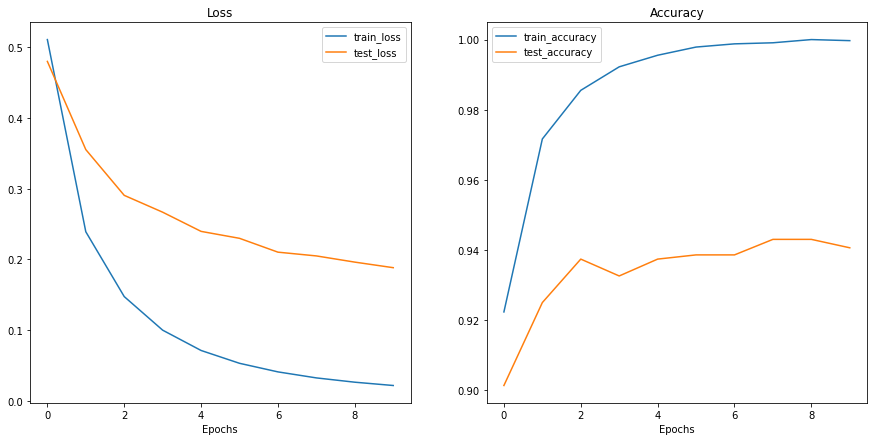

In [29]:
# Plot the loss curves
#from helper_functions import plot_loss_curves

plot_loss_curves(pretrained_vit_results)

In [30]:
"""
Contains various utility functions for PyTorch model training and saving.
"""
import torch
from pathlib import Path

def save_model(model: torch.nn.Module,
               target_dir: str,
               model_name: str):
    """Saves a PyTorch model to a target directory.

    Args:
    model: A target PyTorch model to save.
    target_dir: A directory for saving the model to.
    model_name: A filename for the saved model. Should include
      either ".pth" or ".pt" as the file extension.

    Example usage:
    save_model(model=model_0,
               target_dir="models",
               model_name="05_going_modular_tingvgg_model.pth")
    """
    # Create target directory
    target_dir_path = Path(target_dir)
    target_dir_path.mkdir(parents=True,
                        exist_ok=True)

    # Create model save path
    assert model_name.endswith(".pth") or model_name.endswith(".pt"), "model_name should end with '.pt' or '.pth'"
    model_save_path = target_dir_path / model_name

    # Save the model state_dict()
    print(f"[INFO] Saving model to: {model_save_path}")
    torch.save(obj=model.state_dict(),
             f=model_save_path)

In [32]:
# Save the model
#from going_modular.going_modular import utils

save_model(model=pretrained_vit,
                 target_dir="models",
                 model_name="pretrained_vit_feature_extractor_flowers.pth")

[INFO] Saving model to: models/pretrained_vit_feature_extractor_flowers.pth


In [36]:
#from google.colab import drive
#drive.mount('/content/drive')
!cp models/pretrained_vit_feature_extractor_flowers.pth /content/drive/MyDrive/ #copy from colab to drive
!ls models/

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
pretrained_vit_feature_extractor_flowers.pth


In [38]:
from pathlib import Path

# Get the model size in bytes then convert to megabytes
pretrained_vit_model_size = Path("models/pretrained_vit_feature_extractor_flowers.pth").stat().st_size // (1024*1024) # division converts bytes to megabytes (roughly) 
print(f"Pretrained ViT feature extractor model size: {pretrained_vit_model_size} MB")

Pretrained ViT feature extractor model size: 327 MB


In [45]:
def pred_and_plot_image(
  model: torch.nn.Module,
  image_path: str,
  class_names: List[str] = None,
  transform=None,
  device: torch.device = "cuda" if torch.cuda.is_available() else "cpu",
):
  """Makes a prediction on a target image with a trained model and plots the image.
  Args:
      model (torch.nn.Module): trained PyTorch image classification model.
      image_path (str): filepath to target image.
      class_names (List[str], optional): different class names for target image. Defaults to None.
      transform (_type_, optional): transform of target image. Defaults to None.
      device (torch.device, optional): target device to compute on. Defaults to "cuda" if torch.cuda.is_available() else "cpu".
  
  Returns:
      Matplotlib plot of target image and model prediction as title.
  Example usage:
      pred_and_plot_image(model=model,
                          image="some_image.jpeg",
                          class_names=["class_1", "class_2", "class_3"],
                          transform=torchvision.transforms.ToTensor(),
                          device=device)
  """

  # 1. Load in image and convert the tensor values to float32
  target_image = torchvision.io.read_image(str(image_path)).type(torch.float32)

  # 2. Divide the image pixel values by 255 to get them between [0, 1]
  target_image = target_image / 255.0

  # 3. Transform if necessary
  if transform:
      target_image = transform(target_image)

  # 4. Make sure the model is on the target device
  model.to(device)

  # 5. Turn on model evaluation mode and inference mode
  model.eval()
  with torch.inference_mode():
      # Add an extra dimension to the image
      target_image = target_image.unsqueeze(dim=0)

      # Make a prediction on image with an extra dimension and send it to the target device
      target_image_pred = model(target_image.to(device))

  # 6. Convert logits -> prediction probabilities (using torch.softmax() for multi-class classification)
  target_image_pred_probs = torch.softmax(target_image_pred, dim=1)

  # 7. Convert prediction probabilities -> prediction labels
  target_image_pred_label = torch.argmax(target_image_pred_probs, dim=1)

  # 8. Plot the image alongside the prediction and prediction probability
  plt.imshow(
      target_image.squeeze().permute(1, 2, 0)
  )  # make sure it's the right size for matplotlib
  if class_names:
      title = f"Pred: {class_names[target_image_pred_label.cpu()]} | Prob: {target_image_pred_probs.max().cpu():.3f}"
  else:
      title = f"Pred: {target_image_pred_label} | Prob: {target_image_pred_probs.max().cpu():.3f}"
  plt.title(title)
  plt.axis(False)


In [44]:
!ls data/flowers/test/45/

image_07139.jpg  image_07140.jpg  image_07142.jpg


In [47]:
# import requests

# # Import function to make predictions on images and plot them 
# #from going_modular.going_modular.predictions import pred_and_plot_image

# # Setup custom image path
custom_image_path = Path("data/flowers/test/45/image_07140.jpg")

# # Download the image if it doesn't already exist
# if not custom_image_path.is_file():
#     with open(custom_image_path, "wb") as f:
#         # When downloading from GitHub, need to use the "raw" file link
#         request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/04-pizza-dad.jpeg")
#         print(f"Downloading {custom_image_path}...")
#         f.write(request.content)
# else:
#     print(f"{custom_image_path} already exists, skipping download.")

# Predict on custom image
pred_and_plot_image(model=pretrained_vit,
                    image_path=custom_image_path,
                    class_names=class_names)

AssertionError: ignored